In [198]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from talib import RSI, BBANDS, MACD, ATR, MOM
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [100]:
data = pd.read_csv("./Data/prices.csv")

In [101]:
data.rename(columns={"PX_OPEN": "open",
                     "PX_LAST": "close",
                     "PX_LOW": "low",
                     "PX_HIGH": "high",
                     "PR013": "volume"}, inplace=True)

In [102]:
data

,date,ticker,open,high,low,close,volume
0,2013-01-01,EWZ US Equity,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,EWZ US Equity,45.2353,45.4988,45.1076,45.4748,1.485292e+07
2,2013-01-03,EWZ US Equity,45.2752,46.0576,45.1634,45.7636,1.660947e+07
3,2013-01-04,EWZ US Equity,45.4668,45.7383,45.3471,45.6505,1.177415e+07
4,2013-01-07,EWZ US Equity,45.4429,45.5067,45.1315,45.3913,9.654504e+06
...,...,...,...,...,...,...,...
8851,2021-06-23,XU030 Index,1531.4000,1535.3600,1510.8000,1512.3800,1.683106e+09
8852,2021-06-24,XU030 Index,1516.2300,1530.1300,1516.0900,1522.5500,1.409006e+09
8853,2021-06-25,XU030 Index,1525.7100,1526.4400,1501.7400,1502.1800,1.112987e+09
8854,2021-06-28,XU030 Index,1505.6400,1508.1700,1480.1700,1486.7100,1.543246e+09


In [103]:
data.groupby('ticker').agg({'close': lambda x: x.isnull().sum()})

,close
ticker,
DAX Index,69.0
EWZ US Equity,77.0
XAU Curncy,5.0
XU030 Index,81.0


In [104]:
data = data.sort_values(["ticker", "date"])

In [105]:
data.set_index(["date", "ticker"], inplace=True)

In [106]:
data.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [108]:
data = data.groupby(level="ticker").ffill()
data = data.groupby(level="ticker").bfill()
data

,,open,high,low,close,volume
date,ticker,,,,,
2013-01-01,DAX Index,7689.46,7789.94,7689.46,7778.78,1.403455e+08
2013-01-02,DAX Index,7689.46,7789.94,7689.46,7778.78,1.403455e+08
2013-01-03,DAX Index,7762.13,7777.02,7737.98,7756.44,8.617410e+07
2013-01-04,DAX Index,7740.99,7779.67,7727.55,7776.37,1.015770e+08
2013-01-07,DAX Index,7760.01,7767.55,7713.42,7732.66,1.516954e+08
...,...,...,...,...,...,...
2021-06-23,XU030 Index,1531.40,1535.36,1510.80,1512.38,1.683106e+09
2021-06-24,XU030 Index,1516.23,1530.13,1516.09,1522.55,1.409006e+09
2021-06-25,XU030 Index,1525.71,1526.44,1501.74,1502.18,1.112987e+09


In [50]:
# # compute dollar volume to determine universe
# data['dollar_vol'] = data.loc[:, 'close'].mul(data.loc[:, 'volume'], axis=0)
# data['dollar_vol'] = (data
#                         .groupby('ticker',
#                                  group_keys=False,
#                                  as_index=False)
#                         .dollar_vol
#                         .rolling(window=21)
#                         .mean()
#                         .fillna(0)
#                         .reset_index(level=0, drop=True))
# data.dollar_vol /= 1e3
# data = data.drop("dollar_vol", axis=1)

### Compute the Relative Strength Index

In [109]:
data['rsi'] = data.groupby(level='ticker').close.apply(RSI)

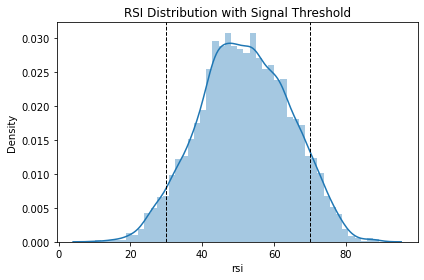

In [110]:
ax = sns.distplot(data.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [111]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [112]:
data = (data.join(data
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [113]:
data['bb_high'] = data.bb_high.sub(data.close).div(data.bb_high).apply(np.log1p)
data['bb_low'] = data.close.sub(data.bb_low).div(data.close).apply(np.log1p)

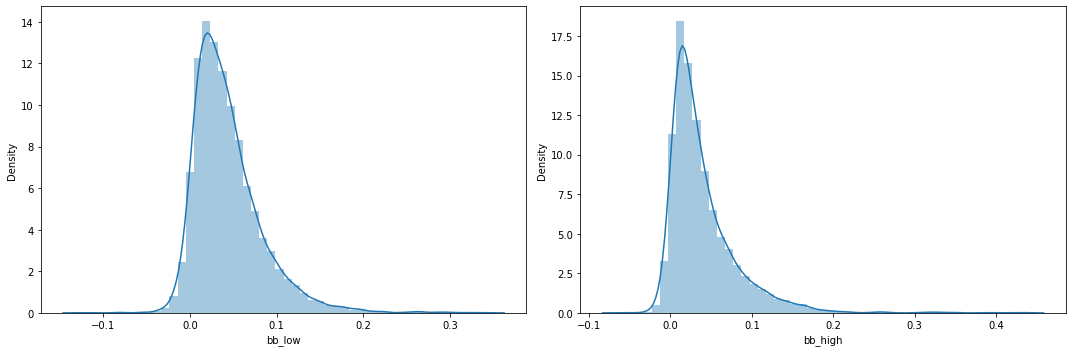

In [114]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(data['bb_low'].dropna(), ax=axes[0])
sns.distplot(data['bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [115]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [116]:
data['atr'] = (data.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

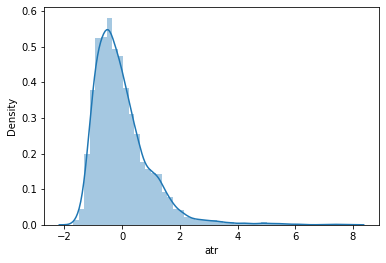

In [117]:
sns.distplot(data.atr.dropna());

### Compute Moving Average Convergence/Divergence

In [118]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [119]:
data['macd'] = (data
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [120]:
data.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    8,724.0
mean         0.0
std          1.0
min         -8.1
0.1%        -6.3
1%          -2.7
2%          -2.1
3%          -1.8
4%          -1.7
5%          -1.6
50%          0.0
95%          1.4
96%          1.5
97%          1.6
98%          1.8
99%          2.1
99.9%        3.4
max          4.7
Name: macd, dtype: object

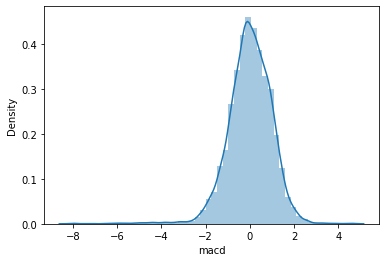

In [121]:
sns.distplot(data.macd.dropna());

### Compute Lagged Returns

In [122]:
lags = [1, 5, 10, 21, 42, 63]

returns = data.groupby(level='ticker').close.pct_change()
percentiles = [.0001, .001, .01]
percentiles += [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,1.55%
min,-23.09%
0.01%,-17.39%
0.1%,-9.19%
1%,-4.27%
50%,0.02%
99%,4.07%
99.9%,7.34%
99.99%,13.57%
max,17.62%


### Winsorize outliers

In [123]:
q = 0.0001
for lag in lags:
    data[f'return_{lag}d'] = (data.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Compute momentum of the close prices, with a time period of 7

In [206]:
def compute_mom(close, time_period=7):
    mom = MOM(close, timeperiod=time_period)
    return pd.DataFrame({'mom': mom}, index=close.index)

In [209]:
data = (data.join(data
                      .groupby(level='ticker')
                      .close
                      .apply(compute_mom)))

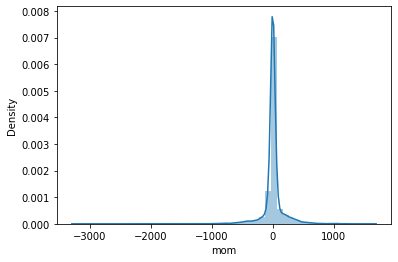

In [210]:
sns.distplot(data.mom.dropna());

### Shift lagged returns

In [124]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        data[f'return_{lag}d_lag{t}'] = (data.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

### Compute Forward Returns

In [125]:
for t in [1, 5, 10, 21]:
    data[f'target_{t}d'] = data.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [126]:
df

,date,ticker,open,high,low,close,volume,rsi,bb_high,bb_low,...,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,target_1d,target_5d,target_10d,target_21d
0,2013-01-01,DAX Index,7689.46,7789.94,7689.46,7778.78,1.403455e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.002142,-0.001330,0.000199
1,2013-01-02,DAX Index,7689.46,7789.94,7689.46,7778.78,1.403455e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.002872,-0.001504,-0.001133,-0.000017
2,2013-01-03,DAX Index,7762.13,7777.02,7737.98,7756.44,8.617410e+07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002569,-0.001240,-0.000271,0.000470
3,2013-01-04,DAX Index,7740.99,7779.67,7727.55,7776.37,1.015770e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.005621,-0.001570,-0.000958,-0.000853
4,2013-01-07,DAX Index,7760.01,7767.55,7713.42,7732.66,1.516954e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.004763,-0.000081,0.000209,-0.000421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,2021-06-23,XU030 Index,1531.40,1535.36,1510.80,1512.38,1.683106e+09,46.388489,0.037196,0.015980,...,-0.000443,-0.000034,-0.006532,0.002727,0.001769,-0.001178,0.006725,NaN,NaN,NaN
8852,2021-06-24,XU030 Index,1516.23,1530.13,1516.09,1522.55,1.409006e+09,49.809232,0.029445,0.018674,...,-0.000007,-0.001384,-0.010965,0.001079,0.000089,-0.001192,-0.013379,NaN,NaN,NaN
8853,2021-06-25,XU030 Index,1525.71,1526.44,1501.74,1502.18,1.112987e+09,43.783283,0.042221,0.006126,...,-0.000206,0.001096,-0.016095,0.001391,-0.000224,-0.001886,-0.010298,NaN,NaN,NaN
8854,2021-06-28,XU030 Index,1505.64,1508.17,1480.17,1486.71,1.543246e+09,39.841148,0.052985,-0.001275,...,0.003395,0.000901,0.008975,0.000042,-0.002662,-0.001521,-0.009955,NaN,NaN,NaN


### Create time related features

In [139]:
data = data.reset_index()
data["date"] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [143]:
data = data.set_index(["date", "ticker"])

In [145]:
data = data.drop("level_0", axis=1)

In [149]:
data['year'] = data.index.get_level_values('date').year
data['month'] = data.index.get_level_values('date').month
data['week'] = data.index.get_level_values('date').week

#### Cyclic features

In [185]:
data['mnth_sin'] = np.sin((data.month-1)*(2.*np.pi/12))
data['mnth_cos'] = np.cos((data.month-1)*(2.*np.pi/12))

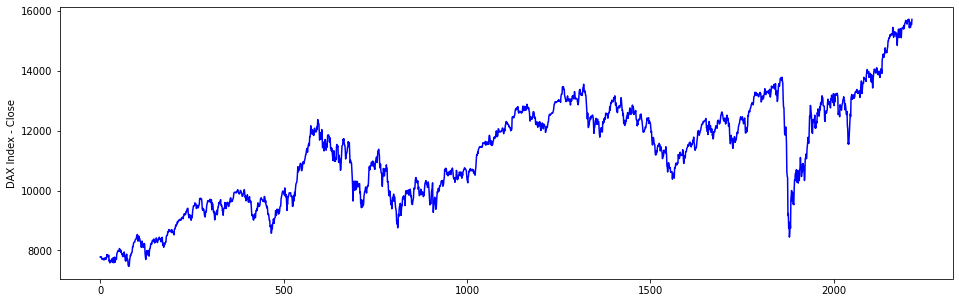

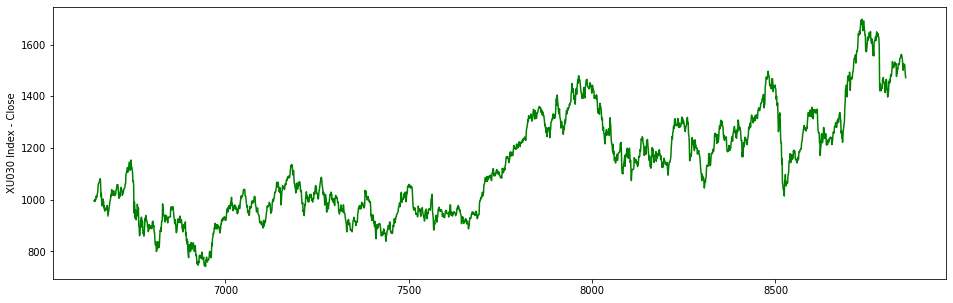

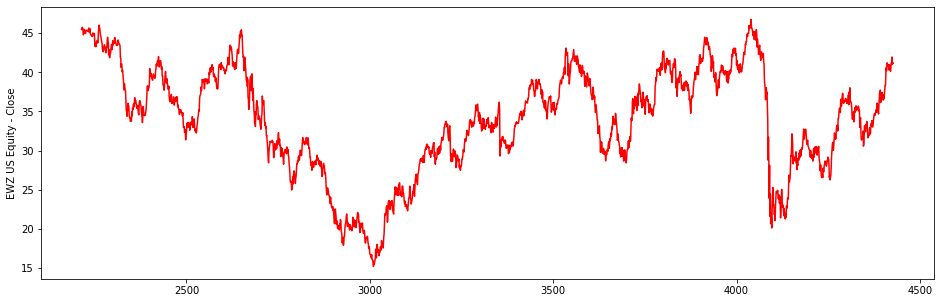

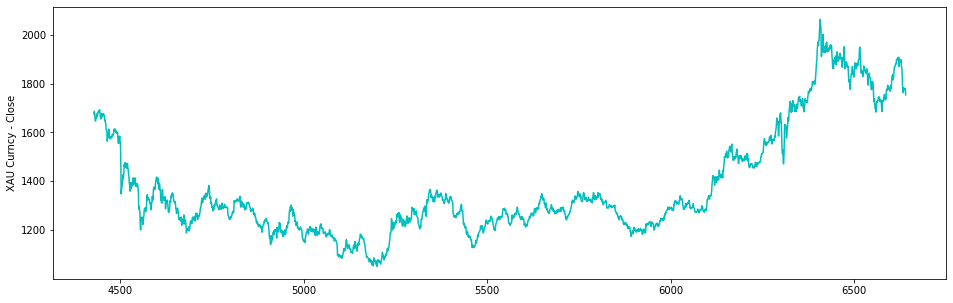

In [129]:
tickers = ['DAX Index', 'XU030 Index', 'EWZ US Equity', 'XAU Curncy']
colors = ['b', 'g', 'r', 'c']
df = data.reset_index()
for ticker, color in zip(tickers, colors):
    plt.figure(figsize=(16, 5))
    ax = df.loc[df["ticker"] == ticker, "close"].plot(color=color, y=ticker)
    ax.set_ylabel(ticker + " - Close")

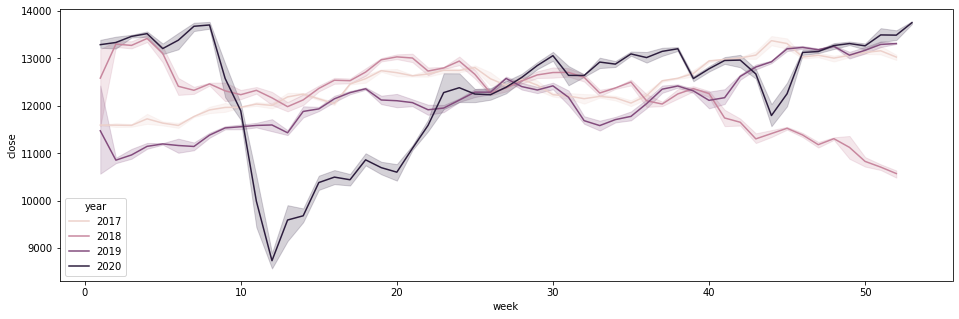

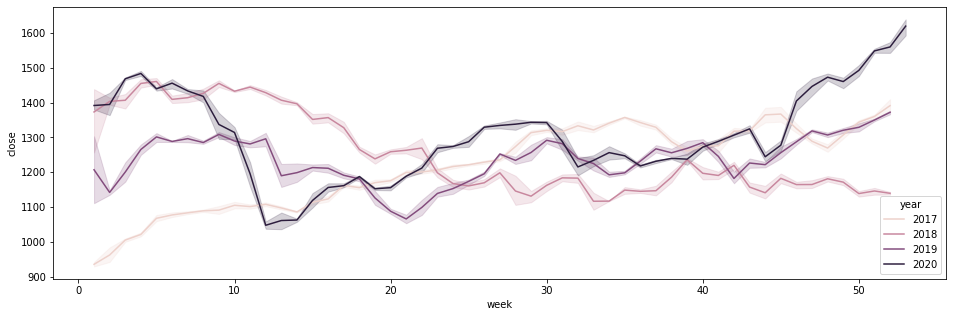

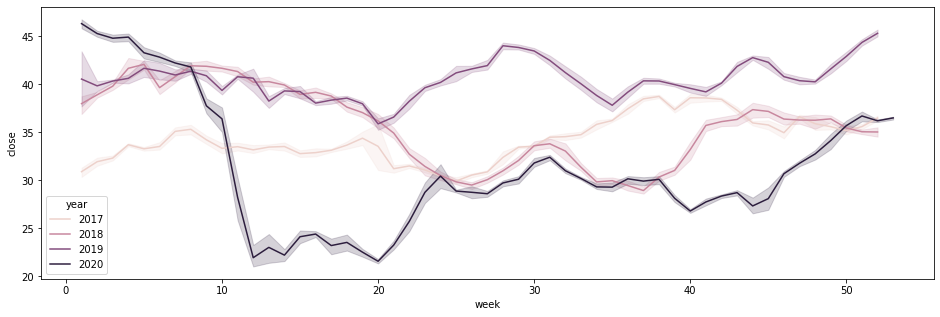

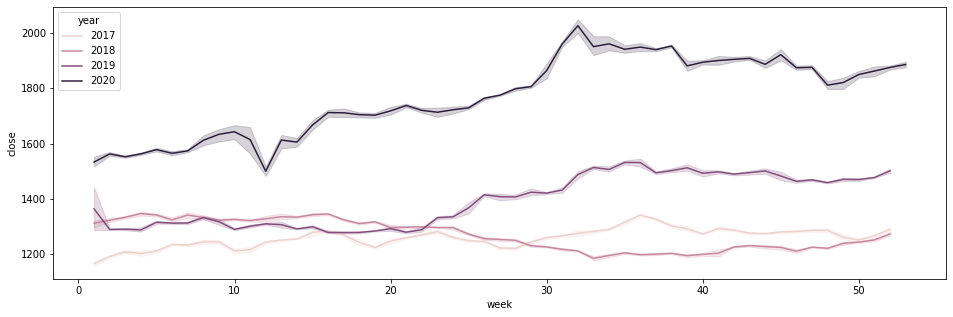

In [158]:
tickers = ['DAX Index', 'XU030 Index', 'EWZ US Equity', 'XAU Curncy']
df = data.reset_index()
for ticker in tickers:
    plt.figure(figsize=(16, 5))
#     ax = df.loc[df["ticker"] == ticker, "close"].plot(color=color, y=ticker)
    sns.lineplot(x='week', y="close", hue='year', legend="full", 
    data=df.loc[(df["ticker"] == ticker) & (df["year"].isin([2017, 2018, 2019, 2020]))])
    ax.set_ylabel(ticker + " - Close")

### RSI

In [160]:
data.loc[:, 'rsi_signal'] = pd.cut(data.rsi, bins=[0, 30, 70, 100])

In [161]:
data.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",372.0,-0.000845,0.011542,-0.064802,-0.003522,-0.000023,0.004274,0.032011
"(30, 70]",7725.0,0.000191,0.006559,-0.054336,-0.003110,0.000538,0.003795,0.039762
"(70, 100]",683.0,0.000060,0.005080,-0.028583,-0.002136,0.000490,0.002947,0.018118


### Bollinger Bands

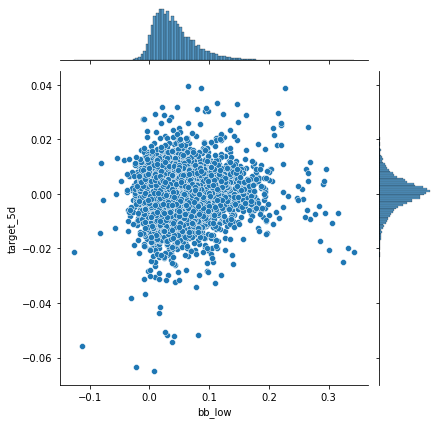

In [197]:
target = 'target_5d'
j=sns.jointplot(x=data.bb_low, y=target, data=data)
# j.ax_joint.text();

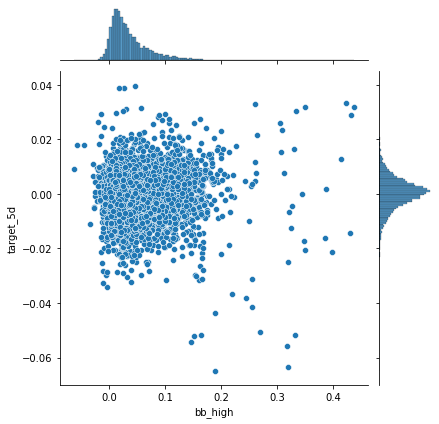

In [187]:
j=sns.jointplot(x=data.bb_high, y=target, data=data)

### ATR

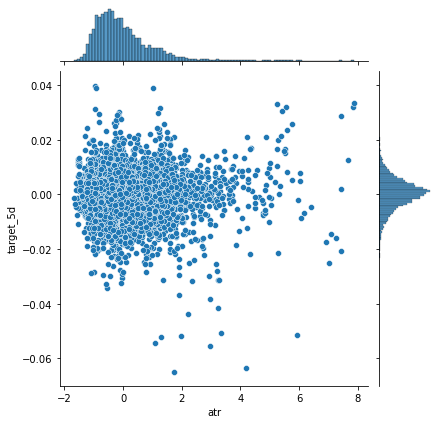

In [188]:
j=sns.jointplot(x=data.atr, y=target, data=data)

### MACD

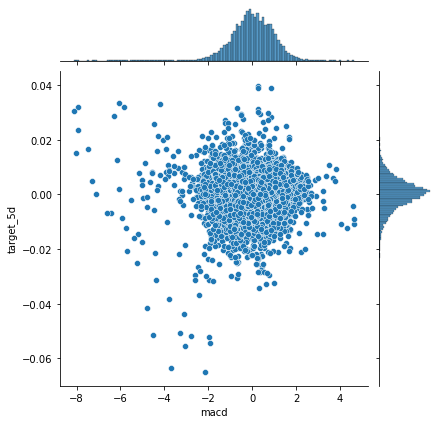

In [189]:
j=sns.jointplot(x=data.macd, y=target, data=data)

In [213]:
data.reset_index().to_csv("./Data/Output/enrich_data.csv", index=False)